# Microsoft Studios - Industry Analysis
### By Yongwei & Yazan

<img src="http://img-prod-cms-rt-microsoft-com.akamaized.net/cms/api/am/imageFileData/RE2qVsJ?ver=3f74">



### The Project
Microsoft sees all the big companies creating original video content, and they want to get in on the fun. They have decided to create a new movie studio, but the problem is they don’t know anything about creating movies. They have hired you to help them better understand the movie industry. Your team is charged with doing data analysis and creating a presentation that explores what type of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the CEO can use when deciding what type of films they should be creating.

### Questions of Interest
The following questions will be analyzed using 2 different measures of success: Review Rating & Commercial Performance. 

Review Rating
    1. What should our standard of success be?
    2. Which genres should we pursue?
    3. How does a film's popularity affect the distribution of ratings within each genre?
    4. Which directors should we consider hiring? (That is, those who have worked on the highest number of top 200 rated films)
    5. Which writers should we consider hiring? (That is, those who have worked on the highest number of top 200 rated films)

Financial Success
    1. What financial matrix we should prioritize? (ROI, Profit, Cost)
    2. What are the most financially successful movies since 2000?
    3. What genre we should pursue for the movie?
    4. What directors we should hire?
    5. What writers we should hire?
    
Finally, when we combine the highest rated films with the most commercially successful:
    1. What are the best performing films across both standards?
    2. What are the most common genres, directors, and writers?
    3. What is the relationship between commercial success and review rating?

### Import packages & connect database

In [1]:
#!pip install mysql-connector-python
#!pip install fuzzywuzzy
#!pip install python-Levenshtein

In [2]:
import pandas as pd
import numpy as np
import mysql.connector
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import string
import seaborn_qqplot as sqp
#from fuzzywuzzy import fuzz
#from fuzzywuzzy import process
%matplotlib inline

In [3]:
con = mysql.connector.connect(user='hbs-student', password='super-secure-password?',
                              host='hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database='movies')
cur = con.cursor()

# Data Cleaning

### IMDB Titles

### In this section: 
- Join all relevant IMDB title tables (imdb_title_basics, imdb_title_crew, imdb_title_ratings) using their common title IDs using a SQL query
- Remove rows with null values for runtime minutes and writers. The number of null values is few in comparison to the very large dataset, so this will not significantly affect our results.
- Convert genres, directors, and writers to lists, so that we can later explode these lists and parse out insights along these 3 variables
- Create a new column showing the "age of the movie", in case it is useful to my analysis later.
- Created a dummy key by removing punctuation marks, digits, and spaces from movie titles and following this format: "yearOfProducton_movie_title", so that we can later connect to our other data sets easily due to the lack of a universal ID column. 

In [4]:
query = ('''
SELECT *
FROM imdb_title_basics imdb_b
JOIN imdb_title_crew imdb_c USING (tconst)
JOIN imdb_title_ratings imdb_e USING (tconst)
''')
imdb_titles = pd.read_sql_query(query, con)
#joining all IMDB title tables using title ids

In [5]:
imdb_titles.isna().sum()
#checking for null values

tconst                 0
primary_title          0
original_title         0
start_year             0
runtime_minutes     7620
genres                 0
directors              0
writers            10561
averagerating          0
numvotes               0
dtype: int64

In [6]:
imdb_titles = imdb_titles.dropna(subset=['runtime_minutes'])
imdb_titles = imdb_titles.dropna(subset=['writers'])
#Removing rows with null values for runtime minutes and writers

In [7]:
pd.set_option('display.max_columns',None)
# Want to see all columns to see which are going to be useful

In [8]:
imdb_titles['genres'] = imdb_titles['genres'].map(lambda x: x.split(','))
imdb_titles['directors'] = imdb_titles['directors'].map(lambda x: x.split(','))
imdb_titles['writers'] = imdb_titles['writers'].map(lambda x: x.split(','))
# Converting genres, directors, writers to lists, so we can easily check most popular later.

In [9]:
imdb_titles['age_of_movie']= 2020 - imdb_titles['start_year']
#Creating new column to have "age of movie" as a reference

In [10]:
translator1 = str.maketrans('0123456789','..........')
translator2 = str.maketrans('', '', string.punctuation)
imdb_titles['dummy_title'] = imdb_titles.primary_title.map(lambda x: x.translate(translator1).translate(translator2).strip())
#Dropping numbers and punctuation marks from primary_title to make a dummy key

imdb_titles['dummy_title'] = imdb_titles['dummy_title'].str.replace('[ ]','_')
imdb_titles['dummy_title'] = imdb_titles['dummy_title'].str.lower()
imdb_titles['dummy_title'] = imdb_titles['dummy_title'].map(lambda x: x.strip())
#Creating a dummy_title column, to be used for our dummy key

In [11]:
imdb_titles['start_year'] = imdb_titles['start_year'].map(lambda x: str(x))
#Turning start_year to string so that I can combine it with dummy_title in another column

In [12]:
imdb_titles['dummy_key'] = imdb_titles['dummy_title'] + "_" + imdb_titles['start_year']
#Creating a new column for dummy_key

In [13]:
imdb_titles = imdb_titles.drop(columns=['dummy_title'])
#removing dummy_title since I have the dummy_key I need

### IMDB Crew

### In this section:
- Create imdb_crew table using SQL query
- Checking for null values in birth year and death year and replacing these values with 0 as a placeholder
- Converted birth year and death year columns into integers, so that we can easily calculate an age if needed later
- Converted primary_profession and known_for_titles columns to lists so that we can later explode these lists and identify crew members who worked on the best films, and what their roles were

In [14]:
query = ('''
SELECT *
FROM imdb_name_basics
''')
imdb_crew = pd.read_sql_query(query, con)

In [15]:
imdb_crew.isna().sum()
# Checking for null values

nconst                     0
primary_name               0
birth_year            523912
death_year            599865
primary_profession         0
known_for_titles           0
dtype: int64

In [16]:
imdb_crew = imdb_crew.fillna(0)
#Replacing null values with 0

In [17]:
imdb_crew['birth_year'] = imdb_crew['birth_year'].map(lambda x: int(x))
imdb_crew['death_year'] = imdb_crew['death_year'].map(lambda x: int(x))
#Converting birth years and death years to integer

In [18]:
imdb_crew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   nconst              606648 non-null  object
 1   primary_name        606648 non-null  object
 2   birth_year          606648 non-null  int64 
 3   death_year          606648 non-null  int64 
 4   primary_profession  606648 non-null  object
 5   known_for_titles    606648 non-null  object
dtypes: int64(2), object(4)
memory usage: 27.8+ MB


In [19]:
imdb_crew['primary_profession'] = imdb_crew['primary_profession'].map(lambda x: x.split(','))
imdb_crew['known_for_titles'] = imdb_crew['known_for_titles'].map(lambda x: x.split(','))
#Converting these to lists so we can easily reference them later

In [20]:
imdb_crew['age'] = imdb_crew.apply(lambda row: (2020 - row['birth_year']) if row['death_year'] == 0 else None, axis=1)
#Adding an age column. If the age is 2020, it means that there is no birth year available. If the age is equal to None, it means the person is dead.

### BOM

In [21]:
query = ('''
SELECT * FROM bom_movie_gross
''')
bom = pd.read_sql_query(query, con)

In [22]:
#drop Null value in domestic_gross
bom = bom.dropna(subset =['domestic_gross'])

#convert Null value in foreign_gross to 0
bom.foreign_gross = bom.foreign_gross.fillna(0)

#convert domestic_gross and foreign_gross from float to int
bom.domestic_gross = bom.domestic_gross.map(lambda x: int(x))   
bom.foreign_gross = bom.foreign_gross.map(lambda x: int(x))  

In [23]:
#remove spaces on both end of strings
bom.title = bom.title.map(lambda x: x.strip())
bom.studio = bom.studio.map(lambda x: x.strip())

In [24]:
#convert year to str
bom['year'] = bom['year'].map(str)

#remove all punctuation and numbers inside movie title
translator1 = str.maketrans('0123456789','..........')
translator2 = str.maketrans('', '', string.punctuation)
bom['title_cleaned'] = bom.title.map(lambda x: x.translate(translator1).translate(translator2).strip())

#combine title and year
bom['title_cleaned'] = bom['title_cleaned'] + '_' + bom['year']

#replace all empty spaces with _ and lower all string
bom['title_cleaned'] = bom['title_cleaned'].str.replace(' ','_').str.lower()

#convert year back to int
bom['year'] = bom['year'].map(int)

### TN

In [25]:
query_tn = ('''
SELECT * FROM tn_movie_budgets
''')
tn = pd.read_sql_query(query_tn, con)

In [26]:
# convert release_date to date format
tn.release_date = tn.release_date.map(lambda x: dt.datetime.strptime(x, '%b %d, %Y'))

# convert production_budget, domestic_gross, worldwide_gross to date format
tn.production_budget = tn.production_budget.map(lambda x: int(x.replace(',','').replace('$','')))
tn.domestic_gross = tn.domestic_gross.map(lambda x: int(x.replace(',','').replace('$','')))
tn.worldwide_gross = tn.worldwide_gross.map(lambda x: int(x.replace(',','').replace('$','')))

#add profit column
tn['profit'] = tn.worldwide_gross - tn.production_budget

# add ROI column to TN table (ROI = profit/production_budget)
tn['roi'] = tn.profit/tn.production_budget

In [27]:
#add new column for release year
tn['year'] = tn.release_date.map(lambda x: str(x.year))

#remove all punctuation and numbers inside movie title
translator1 = str.maketrans('0123456789','..........')
translator2 = str.maketrans('', '', string.punctuation)
tn['title_cleaned'] = tn.movie.map(lambda x: x.translate(translator1).translate(translator2).strip())

#combine title and year
tn['title_cleaned'] = tn['title_cleaned']+'_'+tn['year']

#replace all empty spaces with _ and lower all string
tn['title_cleaned'] = tn['title_cleaned'].str.replace(' ','_').str.lower()

#drop column year
tn = tn.drop(axis = 1, columns='year')

### TMDB

In [28]:
query_tmdb = ('''
SELECT * FROM tmdb_movies
''')
tmdb = pd.read_sql_query(query_tmdb, con)

In [29]:
query_tmdb_link = ('''
SELECT * FROM tmdb_imdb_link
''')
tmdb_link = pd.read_sql_query(query_tmdb_link, con)

In [30]:
#convert genre_ids to int
tmdb.genre_ids.map(lambda x: int(x))

#remove spaces on both end of strings
tmdb.original_language = tmdb.original_language.map(lambda x: x.strip())
tmdb.original_title = tmdb.original_title.map(lambda x: x.strip())
tmdb.title = tmdb.title.map(lambda x: x.strip())

In [31]:
#Join tmdb and tmdb_link tables
tmdb = tmdb.join(tmdb_link.set_index('tmdb_id'), on = 'id', how = 'left')

In [32]:
#clean the joined table
tmdb.imdb_id = tmdb.imdb_id.fillna(0).map(lambda x: int(x))

In [33]:
#add new column for release year
tmdb['year'] = tmdb.release_date.map(lambda x: str(x.year))

#remove all punctuation and numbers inside movie title
translator1 = str.maketrans('0123456789','..........')
translator2 = str.maketrans('', '', string.punctuation)
tmdb['title_cleaned'] = tmdb.title.map(lambda x: x.translate(translator1).translate(translator2).strip())

#combine title and year
tmdb['title_cleaned'] = tmdb['title_cleaned']+'_'+tmdb['year']

#replace all empty spaces with _ and lower all string
tmdb['title_cleaned'] = tmdb['title_cleaned'].str.replace(' ','_').str.lower()

#drop column year
tmdb = tmdb.drop(axis = 1, columns='year')

### RT

In [34]:
query_rt_info = ('''
SELECT * FROM rt_movie_info
''')
rt_info = pd.read_sql_query(query_rt_info, con)

In [35]:
query_rt_reviews = ('''
SELECT * FROM rt_reviews
''')
rt_reviews = pd.read_sql_query(query_rt_reviews, con)

In [36]:
query_rt_link = ('''
SELECT * FROM rt_imdb_link
''')
rt_link = pd.read_sql_query(query_rt_link, con)

### RT_Info Cleaning

In [37]:
#replace empty value in theater_date and dvd_date with Jan 1,1000
rt_info['theater_date'].loc[rt_info.theater_date == ''] = 'Jan 1, 1000'
rt_info['dvd_date'].loc[rt_info.dvd_date == ''] = 'Jan 1, 1000'

C:\Users\yazan\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [38]:
#convert theater_date and dvd_date to datetime format
rt_info.theater_date = rt_info.theater_date.map(lambda x: dt.datetime.strptime(x, '%b %d, %Y').date())
rt_info.dvd_date = rt_info.dvd_date.map(lambda x: dt.datetime.strptime(x, '%b %d, %Y').date())

In [39]:
#clean box_office date
rt_info['box_office'].loc[rt_info.box_office == ''] = '0'
rt_info['box_office'] = rt_info.box_office.map(lambda x: int(x.replace(',', '')))

In [40]:
#clean runtime (replace empty value with 0)
rt_info['runtime'].loc[rt_info.runtime == ''] = '0'
rt_info['runtime'] = rt_info.runtime.map(lambda x: int(x.replace('minutes', '')))

In [41]:
#remove spaces on both end of strings
rt_info.synopsis = rt_info.synopsis.map(lambda x: x.strip())
rt_info.rating = rt_info.rating.map(lambda x: x.strip())
rt_info.genre = rt_info.genre.map(lambda x: x.strip())
rt_info.director = rt_info.director.map(lambda x: x.strip())
rt_info.writer = rt_info.writer.map(lambda x: x.strip())

In [42]:
rt_info['genre'] = rt_info['genre'].map(lambda x: x.split('|'))
rt_info['writer'] = rt_info['writer'].map(lambda x: x.split('|'))
rt_info['director'] = rt_info['director'].map(lambda x: x.split('|'))
#Converting genre, writer, director to list so we can reference them easily

In [43]:
rt_info = rt_info.drop(columns=['box_office','currency'],axis=1)
#Dropping box_office because we have better data on another table, dropping currency because we removed box office data

### RT_Reviews Cleaning

In [44]:
#convert date to datetime format
rt_reviews.date = rt_reviews.date.map(lambda x: dt.datetime.strptime(x, '%B %d, %Y').date())

In [45]:
#convert top_critic to int
rt_reviews.top_critic = rt_reviews.top_critic.map(lambda x: int(x))

In [46]:
#remove spaces on both end of strings
rt_reviews.review = rt_reviews.review.map(lambda x: x.strip())
rt_reviews.rating = rt_reviews.rating.map(lambda x: x.strip())
rt_reviews.fresh = rt_reviews.fresh.map(lambda x: x.strip())
rt_reviews.critic = rt_reviews.critic.map(lambda x: x.strip())
rt_reviews.publisher = rt_reviews.publisher.map(lambda x: x.strip())

### RT_link cleaning

In [47]:
rt_link.year = rt_link.year.fillna(1000)

In [48]:
rt_link.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17468 entries, 0 to 17467
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   imdbid       17468 non-null  int64  
 1   rtid         17468 non-null  int64  
 2   title        17468 non-null  object 
 3   year         17468 non-null  float64
 4   mpaa_rating  17468 non-null  object 
 5   runtime      17468 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 818.9+ KB


In [49]:
#replace empty space to year 1000 in year
rt_link.year = rt_link.year.fillna(1000)

#convert date to datetime format
rt_link.year = rt_link.year.map(lambda x: (int(x)))

In [50]:
#replace empty space in runtime to 0
rt_link['runtime'].loc[rt_link.runtime == ''] = '0'

#convert runtime to int format
rt_link.runtime = rt_link.runtime.map(lambda x: (int(x)))

In [51]:
#convert year to str
rt_link['year'] = rt_link['year'].map(str)

#remove all punctuation and numbers inside movie title
translator1 = str.maketrans('0123456789','..........')
translator2 = str.maketrans('', '', string.punctuation)
rt_link['title_cleaned'] = rt_link.title.map(lambda x: x.translate(translator1).translate(translator2).strip())

#combine title and year
rt_link['title_cleaned'] = rt_link['title_cleaned'] + '_' + rt_link['year']

#replace all empty spaces with _ and lower all string
rt_link['title_cleaned'] = rt_link['title_cleaned'].str.replace(' ','_').str.lower()

#convert year back to int
rt_link['year'] = rt_link['year'].map(int)

# Financial Success Analysis

## 1. What financial success matrix we should focus? (ROI vs Profit)

### Find top hundreds movies after 2000 according to differetn financial success matrix

Both BOM and TN have similar information about budget, but TN database is more complete so we decided to use TN to calculate profit.

In [52]:
# get top 200 revenue domestic movies after 2000
top200_revenue_domestic = tn.loc[tn.release_date>dt.datetime(2000,1,1)].sort_values('domestic_gross',ascending=False).head(200)

# get top 200 revenue worldwide movies after 2000
top200_revenue_world = tn.loc[tn.release_date>dt.datetime(2000,1,1)].sort_values('worldwide_gross',ascending=False).head(200)

# get top 200 profit movies after 2000
top200_profit = tn.loc[tn.release_date>dt.datetime(2000,1,1)].sort_values('profit',ascending=False).head(200)

#get top 200 ROI movies with worldwide_gross higher than 100 million
top200_roi = tn.loc[(tn.release_date>dt.datetime(2000,1,1)) & (tn.worldwide_gross>100000000)].sort_values('roi',ascending=False).head(200)


Combine table for top profit

In [53]:
# Since there are less commone movie between imdb and tn tables. we select top 300 roi movies from tn
# then combine it with imdb movie. We find 196 movies

top300_profit = tn.loc[tn.release_date>dt.datetime(2000,1,1)].sort_values('profit',ascending=False).head(300)

top196_profit_imdb = imdb_titles.loc[imdb_titles.dummy_key.isin(list(top300_profit.title_cleaned))]

# drop original title
top196_profit_imdb = top196_profit_imdb.drop(axis = 1, columns = 'original_title')

#join tn and imdb database together for top 123 movies
top196_profit = top196_profit_imdb.merge(
    top300_profit, left_on='dummy_key', right_on ='title_cleaned').drop(
    axis=1, columns=['start_year', 'id', 'movie', 'title_cleaned'])

combine table for top ROI

In [54]:
# Since there are less commone movie between imdb and tn tables. we select top 300 roi movies from tn
# then combine it with imdb movie. We find 139 movies

#get top 300 ROI movies with worldwide_gross higher than 100 million
top300_roi = tn.loc[(tn.release_date>dt.datetime(2000,1,1)) & (tn.worldwide_gross>100000000)].sort_values('roi',ascending=False).head(300)

top139_roi_imdb = imdb_titles.loc[imdb_titles.dummy_key.isin(list(top300_roi.title_cleaned))]

# drop original title
top139_roi_imdb = top139_roi_imdb.drop(axis = 1, columns = 'original_title')

#join tn and imdb database together for top 103 movies
top139_roi = top139_roi_imdb.merge(
    top300_roi, left_on='dummy_key', right_on ='title_cleaned').drop(
    axis=1, columns=['start_year', 'id', 'movie', 'title_cleaned'])
top139_roi['roi'] = top139_roi['roi'].map(lambda x: round(x, 2))
top139_roi = top139_roi.sort_values('roi',ascending=False)

### Bar plot for top 15 profit and ROI movies.  Scartter plot for top 200 profit and ROI moves

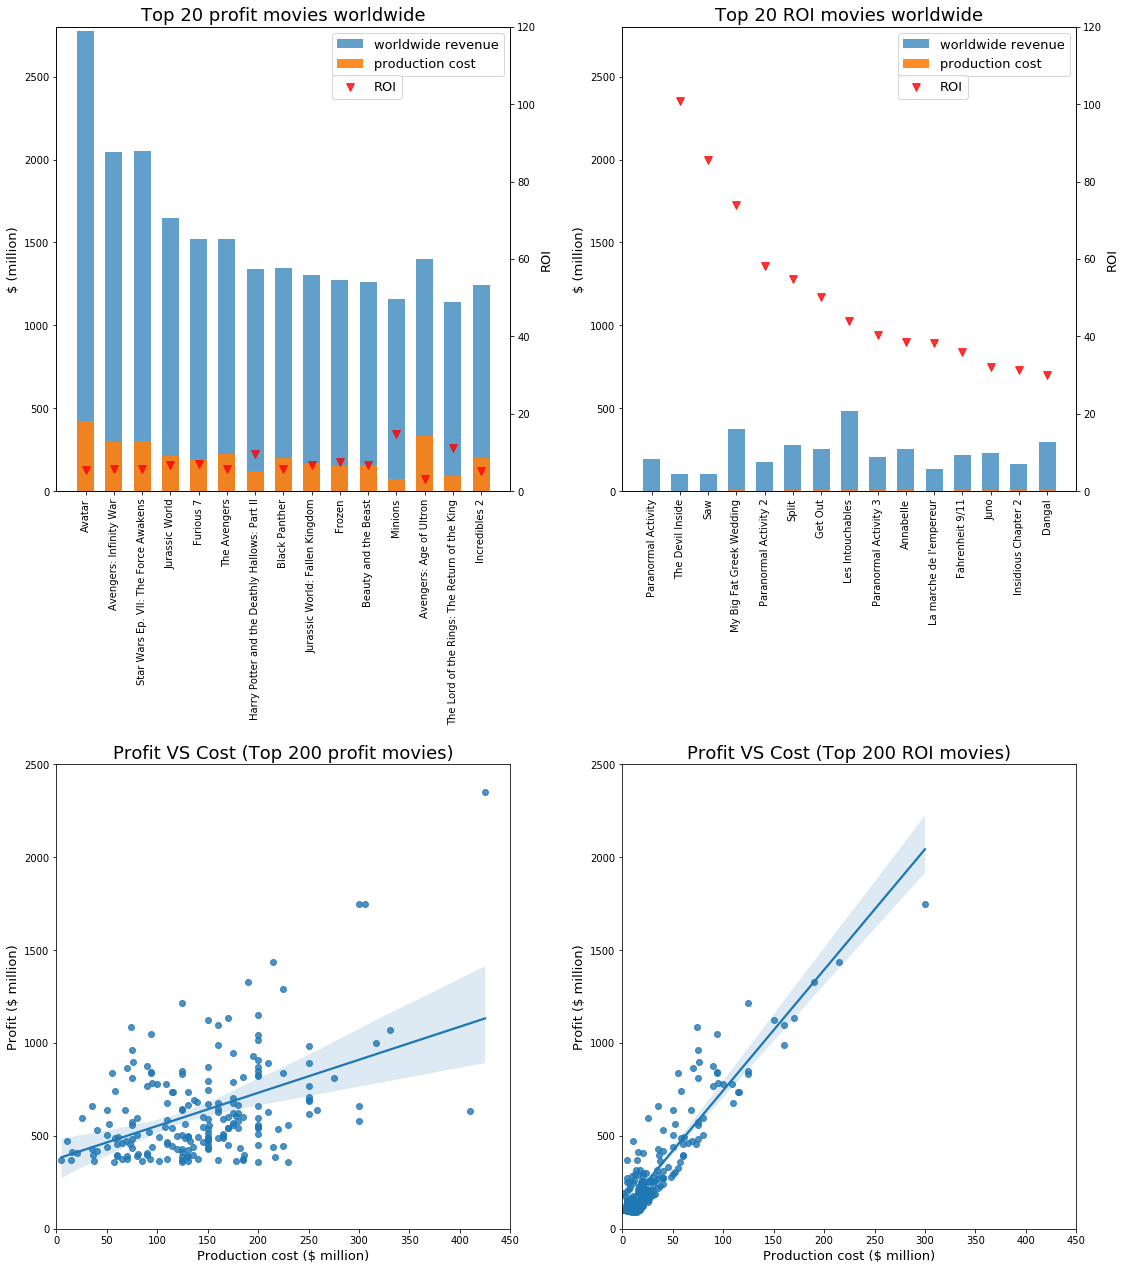

Top 200 movies according to profit:

top 200 profit movies average production cost: 144 million
top 200 profit movies median production cost: 142 million
top 200 profit movies mean profit: 776 million
top 200 profit movies median profit: 701 million
top 200 profit movies mean ROI: 6
top 200 profit movies median ROI: 4


Top 200 movies according to ROI:

top 200 ROI movies average production cost: 36 million
top 200 ROI movies median production cost: 20 million
top 200 ROI movies mean profit: 372 million
top 200 ROI movies median profit: 246 million
top 200 ROI movies mean ROI: 15
top 200 ROI movies median ROI: 9



In [55]:
# use top200_profit table since it is most complete and contain all necessary information
fig = plt.figure(figsize = (16,18))


# top 15 profit movie bar plot
ax1 = fig.add_subplot(2,2,1)
x = top200_profit.head(15).movie
y_revenue = top200_profit.head(15).worldwide_gross/1000000
y_cost = top200_profit.head(15).production_budget/1000000
y_roi = top200_profit.head(15).roi


ax1.bar(x,y_revenue,width = 0.6, alpha=0.7, label = 'worldwide revenue')
ax1.bar(x,y_cost,width = 0.6, alpha=0.9, label = 'production cost')

plt.xticks(rotation=90, fontsize = 10)
plt.yticks(fontsize = 10)
ax1.set_ylabel('$ (million)', fontsize = 13)
ax1.set_ylim(0,2800)
ax1.legend(fontsize = 13)
ax1.set_title('Top 20 profit movies worldwide', fontsize = 18)

ax1_roi = ax1.twinx()
ax1_roi.scatter(x,y_roi, marker = 'v', color = 'red', alpha=0.8, s=60, label='ROI')
ax1_roi.set_ylabel('ROI', fontsize = 13)
ax1_roi.set_ylim(0,120)
ax1_roi.legend(bbox_to_anchor=(0.775, 0.91), fontsize = 13)

#top 20 ROI movie bar plot
ax2 = fig.add_subplot(2,2,2)
x = top200_roi.head(15).movie
y_revenue = top200_roi.head(15).worldwide_gross/1000000
y_cost = top200_roi.head(15).production_budget/1000000
y_roi = top200_roi.head(15).roi

ax2.bar(x,y_revenue,width = 0.6, alpha=0.7, label = 'worldwide revenue')
ax2.bar(x,y_cost,width = 0.6, alpha=0.9, label = 'production cost')
plt.xticks(rotation=90, fontsize = 10)
plt.yticks(fontsize = 10)
ax2.set_ylabel('$ (million)', fontsize = 13)
ax2.set_ylim(0,2800)
ax2.legend(fontsize = 13)
ax2.set_title('Top 20 ROI movies worldwide', fontsize = 18)

ax2_roi = ax2.twinx()
ax2_roi.scatter(x,y_roi, marker = 'v', color = 'red', alpha=0.8, s=60, label='ROI')
ax2_roi.set_ylabel('ROI', fontsize = 13)
ax2_roi.set_ylim(0,120)
ax2_roi.legend(bbox_to_anchor=(0.775, 0.91), fontsize = 13)



#top 200 profit movie scatter plot
ax3 = fig.add_subplot(2,2,3)
x = top200_profit.production_budget/1000000
y = top200_profit.profit/1000000

ax3 = sns.regplot(x=x, y=y)
ax3.set_xlabel('Production cost ($ million)', fontsize = 13)
ax3.set_ylabel('Profit ($ million)', fontsize = 13)
ax3.set_title('Profit VS Cost (Top 200 profit movies)', fontsize = 18)
ax3.set_xlim(0,450)
ax3.set_ylim(0,2500)

fig.tight_layout(pad=2.0)

#top 200 ROI movie scatter plot 
ax4 = fig.add_subplot(2,2,4)
x = top200_roi.production_budget/1000000
y = top200_roi.profit/1000000

ax4 = sns.regplot(x=x, y=y)
ax4.set_xlabel('Production cost ($ million)', fontsize = 13)
ax4.set_ylabel('Profit ($ million)', fontsize = 13)
ax4.set_title('Profit VS Cost (Top 200 ROI movies)', fontsize = 18)
ax4.set_xlim(0,450)
ax4.set_ylim(0,2500)

fig.tight_layout(pad=2.0)
plt.show()



print('Top 200 movies according to profit:'+'\n\n'+
      f'top 200 profit movies average production cost: {int(top200_profit.production_budget.mean()/1000000)} million' +'\n'+ 
      f'top 200 profit movies median production cost: {int(top200_profit.production_budget.median()/1000000)} million' +'\n'+
      f'top 200 profit movies mean profit: {int(top200_profit.worldwide_gross.mean()/1000000)} million' +'\n'+
      f'top 200 profit movies median profit: {int(top200_profit.worldwide_gross.median()/1000000)} million' +'\n'+
      f'top 200 profit movies mean ROI: {int(top200_profit.roi.mean())}' +'\n'+
      f'top 200 profit movies median ROI: {int(top200_profit.roi.median())}' +'\n\n\n'
     'Top 200 movies according to ROI:'+'\n\n'+
      f'top 200 ROI movies average production cost: {int(top200_roi.production_budget.mean()/1000000)} million' +'\n'+ 
      f'top 200 ROI movies median production cost: {int(top200_roi.production_budget.median()/1000000)} million' +'\n'+
      f'top 200 ROI movies mean profit: {int(top200_roi.worldwide_gross.mean()/1000000)} million' +'\n'+
      f'top 200 ROI movies median profit: {int(top200_roi.worldwide_gross.median()/1000000)} million' +'\n'+
      f'top 200 ROI movies mean ROI: {int(top200_roi.roi.mean())}' +'\n'+
      f'top 200 ROI movies median ROI: {int(top200_roi.roi.median())}' +'\n')

#### Conclusion: We should prioritize ROI since most of movies have lower production cost, which means lower risk for Microsoft in the beginning.

### 2. What genres we should pursue?

In [56]:
# Find top genres for top ROI movies
#explode genres to multiple rows
top139_roi_genres = top139_roi.explode('genres')

#count genres
genres_count_roi = top139_roi_genres.genres.value_counts()

#change count to percentage
genres_percentage_roi = round(genres_count_roi.map(lambda x: x/genres_count_roi.sum()),2)

# FInd top genres for top profit movies
#explode genres to multiple rows
top196_profit_genres = top196_profit.explode('genres')

#count genres
genres_count_profit = top196_profit_genres.genres.value_counts()

#change count to percentage
genres_percentage_profit = round(genres_count_profit.map(lambda x: x/genres_count_profit.sum()),2)

print(f'''The top 5 genres for top ROI movies are:\n{genres_percentage_roi.head(5)}\n\n
The top 5 genres for top profit movies are:\n{genres_percentage_profit.head(5)}''')

The top 5 genres for top ROI movies are:
Drama        0.16
Comedy       0.12
Action       0.10
Adventure    0.09
Thriller     0.08
Name: genres, dtype: float64


The top 5 genres for top profit movies are:
Adventure    0.24
Action       0.19
Comedy       0.11
Sci-Fi       0.09
Animation    0.09
Name: genres, dtype: float64


In [57]:
#Pick only top 5 genres movie from top ROI movies
top139_roi_top5genres = top139_roi_genres.loc[top139_roi_genres.genres.isin(genres_percentage_roi.head(5).index)]
#change money units to million
top139_roi_top5genres['production_budget_million'] = top139_roi_top5genres.production_budget.map(lambda x: x/1000000)
top139_roi_top5genres['profit_million'] = top139_roi_top5genres.profit.map(lambda x: x/1000000)
top139_roi_top5genres['domestic_gross_million'] = top139_roi_top5genres.domestic_gross.map(lambda x: x/1000000)
top139_roi_top5genres['worldwide_gross_million'] = top139_roi_top5genres.worldwide_gross.map(lambda x: x/1000000)
top139_roi_top5genres['table'] = 'roi'

#Pick only top 5 genres movie from top profit movies
top196_profit_top5genres = top196_profit_genres.loc[top196_profit_genres.genres.isin(genres_percentage_profit.head(5).index)]
#change money units to million
top196_profit_top5genres['production_budget_million'] = top196_profit_top5genres.production_budget.map(lambda x: x/1000000)
top196_profit_top5genres['profit_million'] = top196_profit_top5genres.profit.map(lambda x: x/1000000)
top196_profit_top5genres['domestic_gross_million'] = top196_profit_top5genres.domestic_gross.map(lambda x: x/1000000)
top196_profit_top5genres['worldwide_gross_million'] = top196_profit_top5genres.worldwide_gross.map(lambda x: x/1000000)
top196_profit_top5genres['table'] = 'profit'


#combine above two table together in order to plot lmplot later
top_joined = pd.concat([top139_roi_top5genres,top196_profit_top5genres])

C:\Users\yazan\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\yazan\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\yazan\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

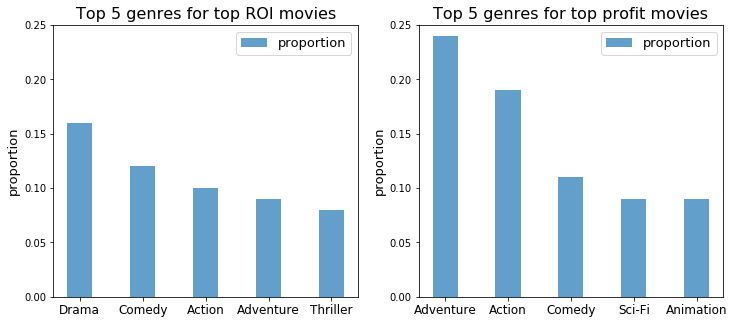

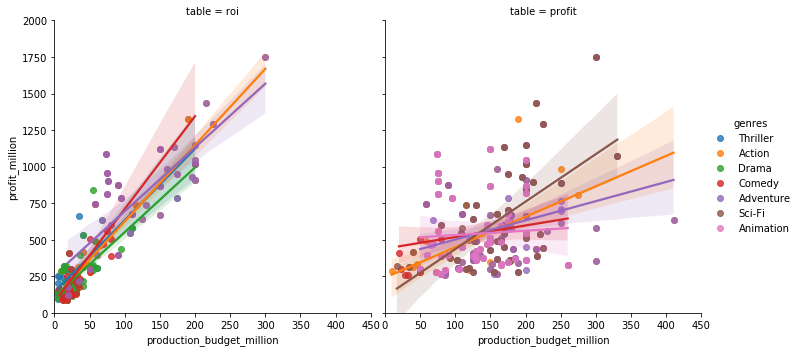

In [58]:
# plot bar plot for genres and regression plot
fig = plt.figure(figsize = (12,5))


# top 5 genres for ROI movie bar plot
ax1 = fig.add_subplot(1,2,1)
x = genres_percentage_roi.head(5).index
y = genres_percentage_roi.head(5).values


ax1.bar(x,y,width = 0.4, alpha=0.7, label = 'proportion')

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 10)
ax1.set_ylabel('proportion', fontsize = 13)
ax1.set_ylim(0,0.25)
ax1.legend(fontsize = 13)
ax1.set_title('Top 5 genres for top ROI movies', fontsize = 16)


# top 5 genres for profit movie bar plot
ax2 = fig.add_subplot(1,2,2)
x = genres_percentage_profit.head(5).index
y = genres_percentage_profit.head(5).values

ax2.bar(x,y,width = 0.4, alpha=0.7, label = 'proportion')

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 10)
ax2.set_ylabel('proportion', fontsize = 13)
ax2.set_ylim(0,0.25)
ax2.legend(fontsize = 13)
ax2.set_title('Top 5 genres for top profit movies', fontsize = 16)


#top genres  regression plot for ROI and profit
ax3 = sns.lmplot(x='production_budget_million', y='profit_million', hue = 'genres', col='table', data = top_joined)
ax3.set(xlim=(0, 450))
ax3.set(ylim=(0, 2000))

plt.show()

#### Conclusion: We should priotize comedy movies since it has higher ROI and also cheap production cost. In the same time, we can also focus on action and adventure movies, since they also have high ROI and  profit

### 3. What directors and writers we shuld hire?

In [59]:
top139_roi.head()

,tconst,primary_title,runtime_minutes,genres,directors,writers,averagerating,numvotes,age_of_movie,dummy_key,release_date,production_budget,domestic_gross,worldwide_gross,profit,roi
45,tt1560985,The Devil Inside,83.0,[Horror],[nm0068587],"[nm0068587, nm1834343]",4.2,33522,8,the_devil_inside_2012,2012-01-06,1000000,53262945,101759490,100759490,100.76
44,tt1536044,Paranormal Activity 2,91.0,[Horror],[nm0931095],"[nm0675219, nm0484907, nm2317082, nm2305431]",5.7,93122,10,paranormal_activity_2010,2010-10-20,3000000,84752907,177512032,174512032,58.17
125,tt5052448,Get Out,104.0,"[Horror, Mystery, Thriller]",[nm1443502],[nm1443502],7.7,400474,3,get_out_2017,2017-02-24,5000000,176040665,255367951,250367951,50.07
61,tt1778304,Paranormal Activity 3,83.0,"[Horror, Mystery, Thriller]","[nm1413364, nm1160962]","[nm0484907, nm2305431]",5.8,85689,9,paranormal_activity_2011,2011-10-21,5000000,104028807,207039844,202039844,40.41
102,tt3322940,Annabelle,99.0,"[Horror, Mystery, Thriller]",[nm0502954],[nm2477891],5.4,122039,6,annabelle_2014,2014-10-03,6500000,84273813,256862920,250362920,38.52


In [60]:
imdb_crew.head()

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles,age
0,nm0000002,Lauren Bacall,1924,2014,"[actress, soundtrack]","[tt0038355, tt0117057, tt0071877, tt0037382]",NaN
1,nm0000003,Brigitte Bardot,1934,0,"[actress, soundtrack, producer]","[tt0049189, tt0057345, tt0054452, tt0059956]",86.0
2,nm0000005,Ingmar Bergman,1918,2007,"[writer, director, actor]","[tt0069467, tt0050986, tt0083922, tt0050976]",NaN
3,nm0000006,Ingrid Bergman,1915,1982,"[actress, soundtrack, producer]","[tt0071877, tt0036855, tt0038109, tt0038787]",NaN
4,nm0000007,Humphrey Bogart,1899,1957,"[actor, soundtrack, producer]","[tt0034583, tt0033870, tt0037382, tt0043265]",NaN


In [61]:
# Find top directors for top ROI movies
#explode directors to multiple rows
top139_roi_directors = top139_roi.explode('directors')
#only select directors who are alive by merging imdb crew table
top_roi_directors_alive = pd.merge(top139_roi_directors,imdb_crew,how = 'left', left_on = 'directors', right_on = 'nconst')
top_roi_directors_alive = top_roi_directors_alive.loc[top_roi_directors_alive.death_year == 0]
#count directors
directors_count_roi = top_roi_directors_alive.primary_name.value_counts()


# Find top writers for top ROI movies
#explode writers to multiple rows
top139_roi_writers = top139_roi.explode('writers')
#only select writers who are alive by merging imdb crew table
top_roi_writers_alive = pd.merge(top139_roi_writers,imdb_crew,how = 'left', left_on = 'writers', right_on = 'nconst')
top_roi_writers_alive = top_roi_writers_alive.loc[top_roi_writers_alive.death_year == 0]
#count writers
writers_count_roi = top_roi_writers_alive.primary_name.value_counts()


# # Find top directors for top profit movies
# #explode directors to multiple rows
# top196_profit_directors = top196_profit.explode('directors')
# #count directors
# directors_count_roi = top196_profit_directors.directors.value_counts()


# # Find top writers for top ROI movies
# #explode writers to multiple rows
# top196_profit_writers = top196_profit.explode('writers')
# #count writers
# writers_count_roi = top196_profit_writers.writers.value_counts()


print(f'''The top 5 directors for top ROI movies are:\n{directors_count_roi.head(5)}\n\n
The top 5 writers for top ROI movies are:\n{writers_count_roi.head(5)}''')

The top 5 directors for top ROI movies are:
James Wan           4
Pierre Coffin       4
Chris Renaud        3
David O. Russell    3
Jordan Peele        2
Name: primary_name, dtype: int64


The top 5 writers for top ROI movies are:
Cinco Paul            4
Ken Daurio            4
Christopher Landon    3
Leigh Whannell        3
Suzanne Collins       3
Name: primary_name, dtype: int64


# Ratings/Reviews as a measure of success

### In this section:
- Because the ratings on the RT table are inconsistent (Some show A+, some 4/5, some 7.5/10, etc), we will use the IMDB and TMDB ratings
- Join these two tables using the imdb ID for each film
- Drop all films released before the year 2000
- Create an "aggregate score" column, which is the product of both ratings, then standardized on a scale of 1-100
- Sum the total number of votes in a new column
- Drop rows where the total number of votes is less than 20,000 so that our data isn't skewed by highly rated films with few votes
- Sort by aggregate rating from highest to lowest
- Identify the top 200 rated films in our dataset and create a bar plot representing the top 20

In [62]:
#To get tmdb['imdb_id'] to line up with the imdb table, I want to remove the "tt" at the beginning of the values in the imdb_titles['tconst'] column.
imdb_titles['tconst'] = imdb_titles['tconst'].str[2:]
#Similarly, I want to make sure that tmdb['imdb_id'] has 7 digits, using 0 as a filler, so that they match
tmdb['imdb_id'] = tmdb['imdb_id'].astype(str).str.rjust(7,'0')

In [63]:
rating = imdb_titles.merge(tmdb,left_on='tconst',right_on='imdb_id')

In [64]:
#Dropping some less relevant columns
rating = rating.drop(columns=['original_title_x','original_title_y','id','genre_ids'])

In [65]:
#Dropping all movies released before the year 2000
rating['start_year'] = rating['start_year'].map(lambda x: int(x))
rating.drop(rating[rating.start_year < 2000].index)

,tconst,primary_title,start_year,runtime_minutes,genres,directors,writers,averagerating,numvotes,age_of_movie,dummy_key,original_language,popularity,release_date,title,vote_average,vote_count,imdb_id,title_cleaned
0,0069049,The Other Side of the Wind,2018,122.0,[Drama],[nm0000080],"[nm0000080, nm0462648]",6.9,4517,2,the_other_side_of_the_wind_2018,en,9.800,2018-11-02,The Other Side of the Wind,7.0,64,0069049,the_other_side_of_the_wind_2018
1,0249516,Foodfight!,2012,91.0,"[Action, Animation, Comedy]",[nm0440415],"[nm0440415, nm0923312, nm0295165, nm0841854, n...",1.9,8248,8,foodfight_2012,en,4.705,2013-05-07,Foodfight!,2.1,46,0249516,foodfight_2013
2,0293069,Dark Blood,2012,86.0,[Thriller],[nm0806293],[nm0059172],6.6,1053,8,dark_blood_2012,en,1.721,2013-03-06,Dark Blood,6.1,7,0293069,dark_blood_2013
3,0315642,Wazir,2016,103.0,"[Action, Crime, Drama]",[nm2349060],"[nm7430071, nm1249226, nm0006765, nm0430785, n...",7.1,15378,4,wazir_2016,hi,3.881,2016-01-08,Wazir,6.6,63,0315642,wazir_2016
4,0323808,The Wicker Tree,2011,96.0,"[Drama, Horror]",[nm0362736],[nm0362736],3.9,2328,9,the_wicker_tree_2011,en,2.962,2012-01-27,The Wicker Tree,4.4,25,0323808,the_wicker_tree_2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9617,9206798,All Is True,2018,101.0,"[Biography, Drama, History]",[nm0000110],[nm0255780],5.9,797,2,all_is_true_2018,en,6.777,2018-12-21,All Is True,6.3,8,9206798,all_is_true_2018
9618,9275202,Breslin and Hamill: Deadline Artists,2018,108.0,[Documentary],"[nm4485929, nm1146602, nm7470181]","[nm1146602, nm0059382, nm4485929, nm3348772, n...",8.1,161,2,breslin_and_hamill_deadline_artists_2018,en,1.047,2018-11-15,Breslin and Hamill: Deadline Artists,8.0,1,9275202,breslin_and_hamill_deadline_artists_2018
9619,9282616,A Cool Fish,2018,109.0,[Comedy],[nm8824211],"[nm8824215, nm8824211]",7.1,929,2,a_cool_fish_2018,zh,2.732,2018-11-16,A Cool Fish,6.6,11,9282616,a_cool_fish_2018
9620,9316022,Struggle: The Life and Lost Art of Szukalski,2018,115.0,[Documentary],[nm2333129],"[nm3530955, nm2333129]",8.1,2018,2,struggle_the_life_and_lost_art_of_szukalski_2018,en,3.591,2018-12-21,Struggle: The Life and Lost Art of Szukalski,8.4,20,9316022,struggle_the_life_and_lost_art_of_szukalski_2018


In [66]:
rating['aggregate_score'] = round(rating.apply(lambda row: row['averagerating'] * row['vote_average'],axis=1),2)
#Creating an aggregate score: (IMDB Rating) * (TMDB average rating)

In [67]:
rating['total_votes'] = rating['numvotes'] + rating['vote_count']
#Creating new column 'total votes'

In [68]:
low_votes = rating[rating['total_votes'] < 20000].index
#Identifying rows where total votes is less than 20,000 because their ratings will be less relevant to my analysis

In [69]:
rating.drop(low_votes, inplace=True)
#Removing those rows

In [70]:
rating['aggregate_score'] = rating['aggregate_score'].map(lambda x: x*100 / max(rating['aggregate_score']))
rating['aggregate_score'] = round(rating['aggregate_score'],2)
#Standardizing the aggregate score on a scale of 0 to 100, and rounding it to 2 decimal places

In [71]:
top_200_rating = rating.sort_values(by=['aggregate_score'],ascending=False).head(200)
#Sorting by highest rated to lowest

## Q1: What should our standard of success be?

In [72]:
rating.aggregate_score.quantile([0.25,0.5,0.75])

0.25    50.11
0.50    59.62
0.75    69.99
Name: aggregate_score, dtype: float64

In [73]:
top_200_rating.aggregate_score.quantile([0.25,0.5,0.75])

0.25    81.0500
0.50    84.3400
0.75    88.6975
Name: aggregate_score, dtype: float64

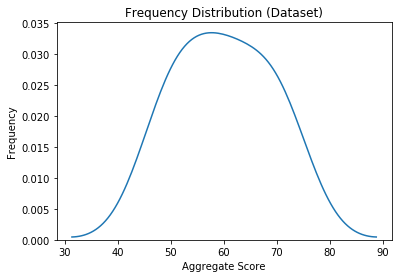

In [74]:
rating_dist = sns.distplot(rating.aggregate_score.quantile([0.25,0.5,0.75]), bins=[30,35,40,45,50,55,60,65,70,75,80,85,90], hist=False)
rating_dist = rating_dist.set(xlabel='Aggregate Score',ylabel='Frequency', title = "Frequency Distribution (Dataset)")


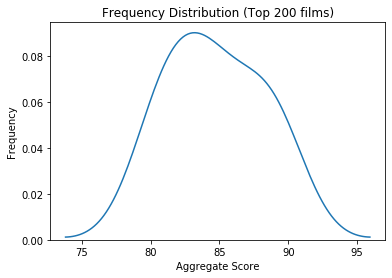

In [75]:
top_200_dist = sns.distplot(top_200_rating.aggregate_score.quantile([0.25,0.5,0.75]), bins=[70,75,80,85,90], hist=False)
top_200_dist = top_200_dist.set(xlabel='Aggregate Score',ylabel='Frequency', title = "Frequency Distribution (Top 200 films)")


## Takeaways
If using rating as a metric for success, we can set benchmarks for films made by Microsoft by using their percentile performance.

- Very poor: 0 (Dataset) - 0.25 (Dataset)
- Poor: 0.25 (Dataset) - 0.5 (Dataset)
- Somewhat Poor: 0.5 (Dataset) - 0.75 (Dataset)
- Satisfactory 0.75 (Dataset) - 0.25 (Top 200)
- Somewhat Successful 0.25 (Top 200) - 0.5 (Top 200)
- Successful 0.5 (Top 200) - 0.75 (Top 200)
- Very Successful 0.75+ (Top 200)

In [76]:
success_measure = {'Aggregate Score': ['0 - 50.10', '50.11 - 59.61', '59.62 - 69.98', '69.99 - 81.04', '81.05 - 84.33', '84.34 - 88.68', '88.69+'],
                    'Classification of Performance': ['Very Poor', 'Poor', 'Somewhat Poor', 'Satisfactory', 'Somewhat Successful', 'Successful', 'Very Successful']}
#Creating a table to classify film scores using above data

In [77]:
df_success_measure = pd.DataFrame(success_measure,columns=['Aggregate Score', 'Classification of Performance'])
df_success_measure

,Aggregate Score,Classification of Performance
0,0 - 50.10,Very Poor
1,50.11 - 59.61,Poor
2,59.62 - 69.98,Somewhat Poor
3,69.99 - 81.04,Satisfactory
4,81.05 - 84.33,Somewhat Successful
5,84.34 - 88.68,Successful
6,88.69+,Very Successful


## Q2: Which genres should we pursue?

In [78]:
genres_popularity = rating [['primary_title', 'popularity', 'genres','aggregate_score','total_votes']]

In [79]:
genres_popularity = genres_popularity.explode('genres')

In [80]:
genres_popularity['genres'] = genres_popularity['genres'].map(lambda x: str(x))
#Converting genres column to a string, so that I can count its frequency

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 <a list of 22 Text xticklabel objects>)

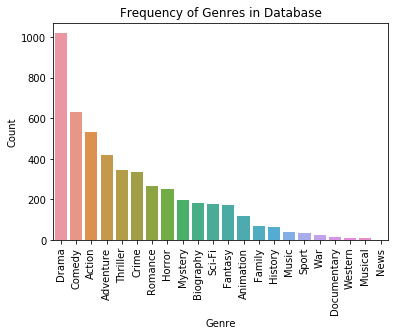

In [81]:
genre_count = sns.countplot(x='genres',data=genres_popularity,order = genres_popularity['genres'].value_counts().index)
genre_count = genre_count.set(xlabel='Genre',ylabel='Count', title = "Frequency of Genres in Database")
plt.xticks(rotation=90)

### Looking at the top 10 most frequently identified genres, what is the distribution of rating scores for each genre?

In [82]:
top_10_genres = genres_popularity[genres_popularity['genres'].isin(['Drama','Adventure','Action','Comedy','Biography','Animation','Crime','Sci-Fi','Mystery','Thriller']) ]
#Picking films only from the top 10 genres

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

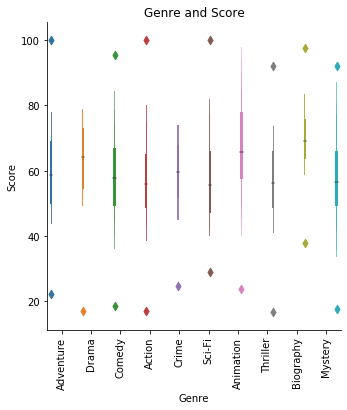

In [83]:
genre_swarm = sns.catplot(x='genres',y="aggregate_score",data=top_10_genres,hue="genres",kind="boxen")
genre_swarm = genre_swarm.set(xlabel='Genre',ylabel='Score', title = "Genre and Score")
plt.xticks(rotation=90)

## Takeaways
If Microsoft want to take a risk-averse approach, and release a film that has the highest chance of meeting a "Satisfactory" aggregate score, the best genres to pursue are:
1. Biography
2. Animation
3. Drama

However, if they wish to take a more risky approach, the highest overall scores are earned by films in the following genres:
1. Adventure
2. Action
3. Sci-Fi

In [84]:
top_3_safe = top_10_genres[top_10_genres['genres'].isin(['Biography','Animation','Drama']) ]
top_3_risky = top_10_genres[top_10_genres['genres'].isin(['Adventure','Action','Sci-Fi']) ]


## Q3: How does a film's popularity affect the distribution of its ratings?

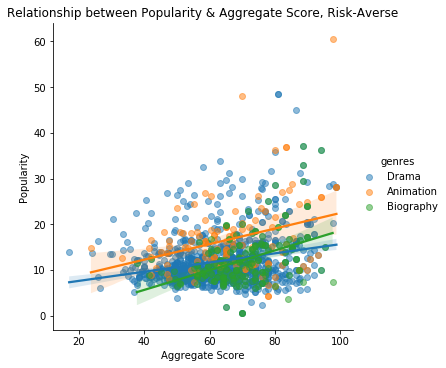

In [85]:
scatter_score_totalvotes = sns.lmplot(x='aggregate_score',y='popularity',data=top_3_safe,hue='genres',scatter_kws={'alpha':0.5})
scatter_score_totalvotes.set(xlabel='Aggregate Score',ylabel='Popularity', title = "Relationship between Popularity & Aggregate Score, Risk-Averse")



### Takeaways
1. Biography films tend to get higher scores, but lower overall popularity
2. Drama films tend to be more popular, regardless of aggregate score
3. Animation films tend to be the most popular and high-scoring films within this subset

If Microsoft wishes to use a risk-averse approach, animation seems to be the best option to pursue.

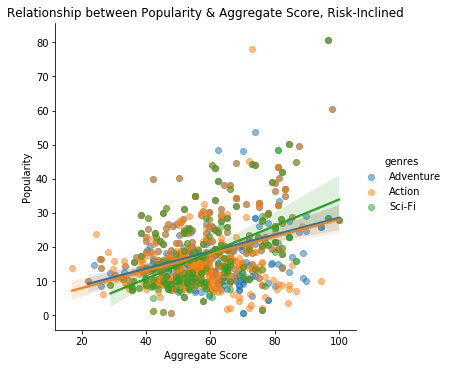

In [86]:
scatter_score_totalvotes = sns.lmplot(x='aggregate_score',y='popularity',data=top_3_risky,hue='genres',scatter_kws={'alpha':0.5})
scatter_score_totalvotes.set(xlabel='Aggregate Score',ylabel='Popularity', title = "Relationship between Popularity & Aggregate Score, Risk-Inclined")

### Takeaways
1. Action and Adventure films seem to be closely correlated
2. Sci-Fi films tend to be more popular at higher scores compared to Adventure and Action films. 

If Microsoft wishes to use a risk-inclined approach, Sci-Fi seems to be the best option to pursue.

## Q4: Which directors should we consider hiring? (That is, those who have worked on the highest number of highly rated films within our identified genres)

In [87]:
top_200_directors = top_200_rating [['primary_title', 'popularity', 'genres','aggregate_score','total_votes','directors']]
#Creating a new table to identify best directors of top 200 films

In [88]:
top_200_directors = top_200_directors.explode('directors')
top_200_directors = top_200_directors.explode('genres')
#Splitting directors and genres into different rows

In [89]:
top_200_directors = top_200_directors.merge(imdb_crew,right_on='nconst',left_on='directors')
#Joining imdb_crew table to identify direcotrs by their ID

In [90]:
top_200_directors = top_200_directors[['primary_title','popularity','aggregate_score','total_votes','primary_name','death_year','age','genres']]
#Keeping only the columns that I will need

In [91]:
top_200_directors = top_200_directors.drop(top_200_directors[top_200_directors['age'] == 'None' ].index)
#Removing all deceased directors

C:\Users\yazan\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [92]:
top_200_directors_safe = top_200_directors[top_200_directors['genres'].isin(['Biography','Animation','Drama']) ]
top_200_directors_risky = top_200_directors[top_200_directors['genres'].isin(['Adventure','Action','Sci-Fi']) ]
#Creating 2 new tables separating different genres

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

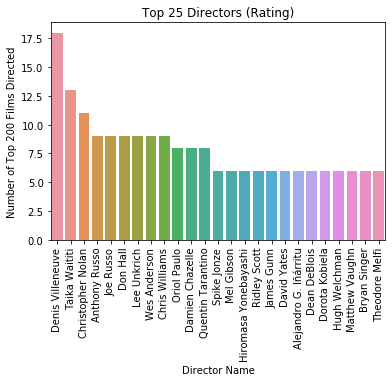

In [93]:
top_directors_rating = sns.countplot(x='primary_name',data=top_200_directors,order = top_200_directors['primary_name'].value_counts().head(25).index)
top_directors_rating = top_directors_rating.set(xlabel='Director Name',ylabel='Number of Top 200 Films Directed', title = "Top 25 Directors (Rating)")
plt.xticks(rotation=90)

### Takeaways
Our top 10 directors overall are
1. Denis Villenueve
2. Taika Waititi
3. Christopher Nolan
4. Don Hall
5. Wes Anderson
6. Anthony Russo
7. Chris Williams
8. Lee Unkrich
9. Joe Russo
10. Oriol Paulo

### Risk-Averse Subset (Drama, Animation, Biography

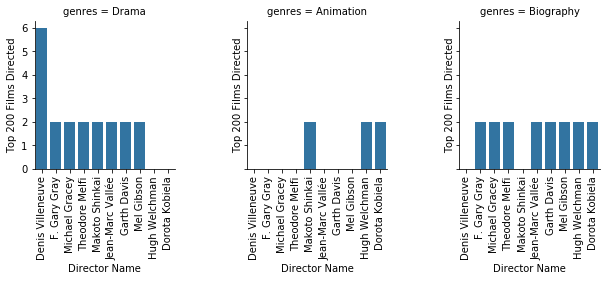

In [94]:
directors_norisk = sns.FacetGrid(top_200_directors_safe, col='genres')
directors_norisk.map(sns.countplot, "primary_name", order = top_200_directors_safe['primary_name'].value_counts().head(10).index)
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in directors_norisk.axes.flat]
directors_norisk = directors_norisk.set(xlabel='Director Name',ylabel='Top 200 Films Directed')



### Takeaways
The above graph shows the genre breakdown of films directed by the top 10 directors within the risk-averse subset.

The directors to pursue for each category are:

Drama
1. Denis Villeneuve
2. F Gary Gray
3. Garth Davis
4. Makoto Shinkai
5. Michael Gracey
6. Jean_Marc Vallee
7. Mel Gibson

Animation
1. Dorota Kobiela
2. Makoto Shinkai
3. Hugh Welchman

Biography
1. F Gary Gray
2. Doriota Kobiela
3. Garth Davis
4. Michael Gracey
5. Jean-Marc Vallee
6. Theodore Melfi
7. Hugh Welchman
8. Mel Gibson

### Risk-Inclined Subset (Action, Adventure, Sci-Fi)

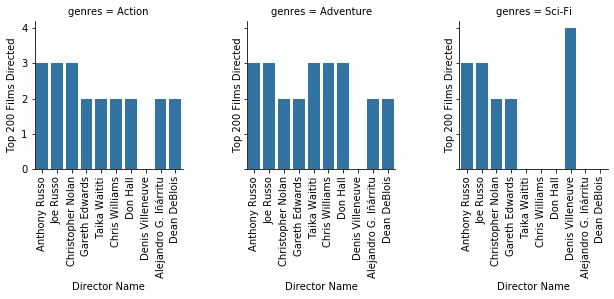

In [95]:
directors_risky = sns.FacetGrid(top_200_directors_risky, col='genres')
directors_risky.map(sns.countplot, "primary_name", order = top_200_directors_risky['primary_name'].value_counts().head(10).index)
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in directors_risky.axes.flat]
directors_risky = directors_risky.set(xlabel='Director Name',ylabel='Top 200 Films Directed')



### Takeaways
The above graph shows the genre breakdown of films directed by our top 10 directors within the risky subset.

The best directors to pursue for each category are:

Action
1. Joe Russo
2. Anthony Russo
3. Christopher Nolan

Adventure
1. Joe Russo
2. Anthony Russo
3. Taika Waititi
4. Chris Williams
5. Don Hall

Sci-Fi
1. Denis Villeneuve
2. Joe Russo
3. Anthony Russo

## Q4: Which writers should we consider hiring? (That is, those who have worked on the highest number of highly rated films within our identified genres)

In [96]:
top_200_writers = top_200_rating [['primary_title', 'popularity', 'genres','aggregate_score','total_votes','writers']]
#Following same process for top writers

In [97]:
top_200_writers = top_200_writers.explode('writers')
top_200_writers = top_200_writers.explode('genres')

In [98]:
top_200_writers = top_200_writers.merge(imdb_crew,right_on='nconst',left_on='writers')

In [99]:
top_200_writers = top_200_writers[['primary_title','popularity','aggregate_score','total_votes','primary_name','death_year','age','genres']]

In [100]:
top_200_writers = top_200_writers.drop(top_200_writers[top_200_writers['age'] == 'None'].index)
#Removing all deceased writers

In [101]:
top_200_writers_safe = top_200_writers[top_200_writers['genres'].isin(['Biography','Animation','Drama']) ]
top_200_writers_risky = top_200_writers[top_200_writers['genres'].isin(['Adventure','Action','Sci-Fi']) ]
#Creating 2 new tables separating different genres

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

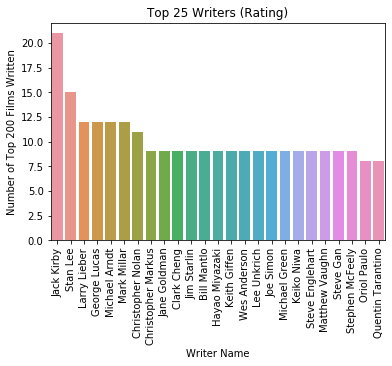

In [102]:
top_writers_rating = sns.countplot(x='primary_name',data=top_200_writers,order = top_200_writers['primary_name'].value_counts().head(25).index)
top_writers_rating = top_writers_rating.set(xlabel='Writer Name',ylabel='Number of Top 200 Films Written', title = "Top 25 Writers (Rating)")
plt.xticks(rotation=90)

### Takeaways
Our top 10 writers overall are
1. Jack Kirby
2. Stan Lee
3. Mark Millar
4. George Lucas
5. Michael Arndt
6. Christopher Nolan
7. Jane Goldman
8. Michael Green
9. Steve Gan
10. Keith Giffen

### Risk-Averse Subset (Drama, Animation, Biography

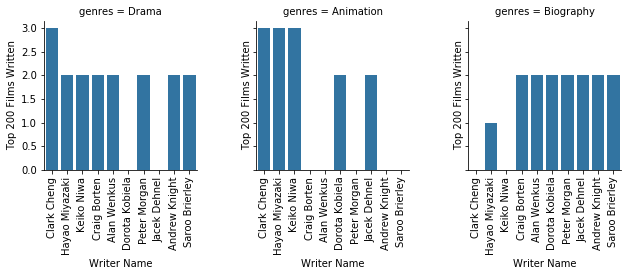

In [103]:
writers_norisk = sns.FacetGrid(top_200_writers_safe, col='genres')
writers_norisk.map(sns.countplot, "primary_name", order = top_200_writers_safe['primary_name'].value_counts().head(10).index)
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in writers_norisk.axes.flat]
writers_norisk = writers_norisk.set(xlabel='Writer Name',ylabel='Top 200 Films Written')


### Takeaways
The above graphs show the genre breakdown of films directed by our top 10 writers within the risk averse subset.

The best writers to pursue for each category are:

Drama
1. Clark Cheng
2. All others

Animation
1. Hayao Miyazaki
2. Clark Cheng
3. Keiko Niwa

Biography
1. Luke Davies
2. Saroo Brierley
3. Melisa Wallack
4. Craig Broten
5. Theodore Melfi
6. Robert Schenkkan 
7. Andrea Berloff

### Risk-Inclined Subset (Action, Adventure, Sci-Fi)

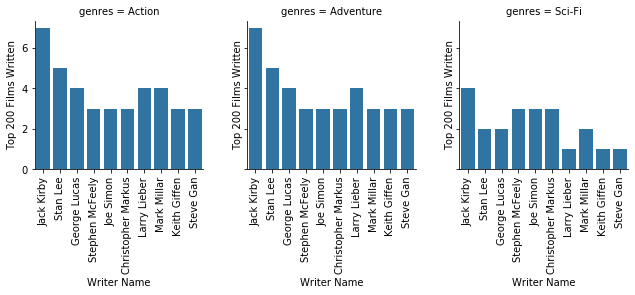

In [104]:
writers_risky = sns.FacetGrid(top_200_writers_risky, col='genres')
writers_risky.map(sns.countplot, "primary_name", order = top_200_writers_risky['primary_name'].value_counts().head(10).index)
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in writers_risky.axes.flat]
writers_risky = writers_risky.set(xlabel='Writer Name',ylabel='Top 200 Films Written')



### Takeaways
The above graphs show the genre breakdown of films directed by our top 10 writers within the risk inclined subset.

The best writers to pursue for each category are:

Action
1. Jack Kirby
2. Stan Lee
3. George Lucas
4. Mark Millar
5. Larry Lieber

Adventure
1. Jack Kirby
2. Stan Lee
3. George Lucas
5. Larry Lieber

Sci-Fi
1. Jack Kirby
2. Christopher Markus
3. Stephen McFeely
4. Joe Simon

## Review Rating Findings Recap
    1. Observation 1
    2. Observation 2
    3. Observation 3

## Financial Success Findings Recap
    1. Observation 1
    2. Observation 2
    3. Observation 3

## Business Recommendations
    1. Recommendation 1
    2. Recommendation 2
    3. Recommendation 3

## Limitations
    1. Limitation 1
    2. Limitation 2
    3. Limitation 3